In [424]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

In [425]:
use_cuda = torch.cuda.is_available()

In [426]:
def ode_solve(z0, t0, t1, f):
    """
    Простейший метод эволюции ОДУ - метод Эйлера
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    #print(z0,t0,"haha")
    return z

In [427]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs

        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )

        # метод grad автоматически суммирует градие*н*ты для всех элементов батча, надо expand их обратно 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size

        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [428]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF) # является ли func типа ODEF
        bs, *z_shape = z0.size()
        
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Динамика аугментированной системы, которую надо эволюционировать обратно во времени
        def augmented_dynamics(aug_z_i, t_i):
            """
            Тензоры здесь - это срезы по времени
            t_i - тензор с размерами: bs, 1
            aug_z_i - тензор с размерами: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # игнорируем параметры и время

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz для удобства
        with torch.no_grad():
            ## Создадим плейсхолдеры для возвращаемых градиентов
            # Распространенные назад сопряженные состояния, которые надо поправить градиентами от наблюдений
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # В отличие от z и p, нужно вернуть градиенты для всех моментов времени
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Рассчитаем прямые градиенты от наблюдений
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Подправим ими сопряженные состояния
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Упакуем аугментированные переменные в вектор
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Решим (эволюционируем) аугментированную систему назад во времени
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Распакуем переменные обратно из решенной системы
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Подправим сопряженное состояние в нулевой момент времени прямыми градиентами
            # Вычислим прямые градиенты
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Подправим
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [429]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__() # Используем родительский класс?
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func) # здесь передаем параметры нашей функции
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [430]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

In [431]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[3, 0], [-3, -1]]))

In [432]:
class NotRandomLinearODEF(LinearODEF):
    def __init__(self):
        super(NotRandomLinearODEF, self).__init__(Tensor([[1, 1], [-1, 1]]))

In [433]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

In [434]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        #print(torch.sigmoid(xTx0)) #удали потом
        return dxdt

In [435]:
class TestODEF2(ODEF):
    def __init__(self, A, B):
        super(TestODEF2, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)


    def forward(self, x, t):

        dxdt =self.A(x)
        #print(torch.sigmoid(xTx0)) #удали потом
        return dxdt

In [436]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [437]:
def to_np(x):
    return x.detach().cpu().numpy()

In [438]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [451]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()

    obs = obs + torch.randn_like(obs) * 0.01 #Вот тут создается этот датасет

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        #print(obs_[0])
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()
        
        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)
            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"assets/imgs/{name}/{i}.png")
            
            clear_output(wait=True)

In [440]:
t_max = 6.29*5
n_points = 200

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
ode_true = NeuralODE(SpiralFunctionExample())
z0 = Variable(torch.Tensor([[100, 3]]))
times = torch.from_numpy(times_np[:, :, None]).to(z0)
a = ode_true(z0, times, return_whole_sequence=True).detach()

In [441]:
a

tensor([[[ 1.0000e+02,  3.0000e+00]],

        [[ 1.5653e+02, -5.1011e+01]],

        [[ 2.4501e+02, -1.2726e+02]],

        [[ 3.8351e+02, -2.3954e+02]],

        [[ 6.0029e+02, -4.0930e+02]],

        [[ 9.3962e+02, -6.6989e+02]],

        [[ 1.4708e+03, -1.0734e+03]],

        [[ 2.3022e+03, -1.7014e+03]],

        [[ 3.6035e+03, -2.6812e+03]],

        [[ 5.6405e+03, -4.2121e+03]],

        [[ 8.8289e+03, -6.6061e+03]],

        [[ 1.3820e+04, -1.0352e+04]],

        [[ 2.1632e+04, -1.6212e+04]],

        [[ 3.3859e+04, -2.5385e+04]],

        [[ 5.2999e+04, -3.9741e+04]],

        [[ 8.2959e+04, -6.2212e+04]],

        [[ 1.2985e+05, -9.7384e+04]],

        [[ 2.0326e+05, -1.5244e+05]],

        [[ 3.1815e+05, -2.3861e+05]],

        [[ 4.9799e+05, -3.7349e+05]],

        [[ 7.7950e+05, -5.8462e+05]],

        [[ 1.2201e+06, -9.1510e+05]],

        [[ 1.9098e+06, -1.4324e+06]],

        [[ 2.9894e+06, -2.2421e+06]],

        [[ 4.6793e+06, -3.5095e+06]],

        [[ 7.3244e+06, -5

In [442]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

In [443]:
conduct_experiment(ode_true, ode_trained, 10000, "linear")

KeyboardInterrupt: 

In [332]:
start_time = time.time()
conduct_experiment(ode_true, ode_trained, 2000, "linear")
print("--- %s seconds ---" % round((time.time() - start_time),2))

--- 64.8 seconds ---


In [460]:
for parameter in ode_trained.parameters():
    print(parameter.data) # охереть. Это параметры модели

tensor([[-1.0067,  0.0014]])
tensor([[-0.0996, -0.4901],
        [ 0.5088, -0.1031]])
tensor([[ 0.1983,  1.0043],
        [-0.9989,  0.2074]])


In [458]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

#func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

In [445]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]], Tensor([[-1., 0.]])))
ode_true = NeuralODE(func)
ode_trained = NeuralODE(func)


TypeError: new() received an invalid combination of arguments - got (list, Tensor), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m, [31;1mTensor[0m)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [459]:
conduct_experiment(ode_true, ode_trained, 4000, "comp", plot_freq=30)

KeyboardInterrupt: 

In [456]:
func.flatten_parameters()

tensor([ 1.0238e+00, -2.2215e-01,  7.9349e-03, -2.6995e-01,  7.1871e-03,
        -1.6217e-02, -2.5295e-02, -6.7903e-02,  3.6924e-02, -5.7561e-03,
         1.8917e-02, -3.6380e-02, -7.6289e-03,  3.3590e-02, -1.4382e-03,
        -3.8194e-02, -1.2934e-01, -2.6460e-01,  1.0217e+00,  6.3184e-01,
        -9.3379e-01, -8.8210e-01, -9.6443e-01,  4.1504e-01,  2.0000e-02,
         2.6537e-02,  1.4537e-01,  1.2731e-02,  1.7225e-02, -2.8079e-02,
         4.9140e-01, -1.1734e+00, -1.2243e+00,  6.1893e-02, -7.1930e-03,
        -2.7050e-02,  5.4543e-02,  1.0742e-01,  8.1082e-03, -3.9156e-02,
        -6.3323e-04, -7.3478e-01, -1.0597e+00, -9.3034e-01,  7.0177e-03,
        -4.9468e-01,  1.0230e-03, -1.0050e+00, -1.3229e-01, -2.5574e-02,
        -5.2437e-02, -8.7804e-03,  2.7695e-02, -1.1952e-01, -1.3921e-02,
         6.5105e-02, -1.7713e-01, -7.7703e-01, -2.9946e-01,  2.6963e-01,
         8.6850e-02,  8.3975e-02,  3.8482e-03,  6.1624e-01,  8.5082e-01,
         1.4961e-01,  1.1127e-01, -6.8757e-03,  1.0

In [113]:
ode_trained.func

TestODEF(
  (A): Linear(in_features=2, out_features=2, bias=False)
  (B): Linear(in_features=2, out_features=2, bias=False)
)

In [114]:
obs

NameError: name 'obs' is not defined

In [115]:
func.forward_with_grad(0,0,0)

AttributeError: 'int' object has no attribute 'shape'

In [116]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

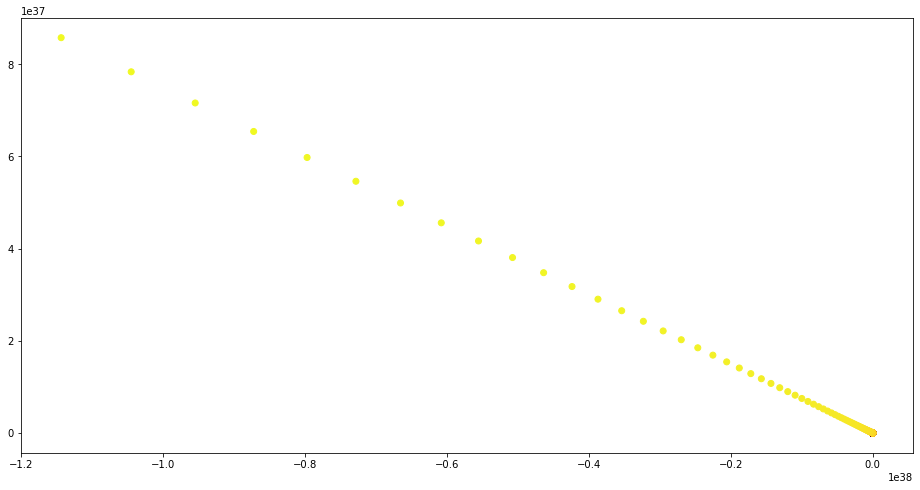

In [344]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

In [43]:
for parameter in ode_trained.parameters():
    print(parameter.data) # охереть. Это параметры модели

tensor([[0.0500, 0.0595]])
tensor([[-3.0885,  2.9127],
        [-0.2834,  0.7222]])
tensor([[0.0541, 0.0541],
        [0.0545, 0.0545]])


In [47]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

In [ ]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

In [28]:
ode_true

AttributeError: 'NeuralODE' object has no attribute 'A'

In [132]:
for parameter in ode_trained.parameters():
    print(parameter.data) # охереть. Это параметры модели

tensor([[nan, nan],
        [nan, nan]])


In [23]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[0., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)